In [67]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [68]:
%matplotlib inline
#from __future__ import division
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
from pylab import *
pass

In [69]:
# Define some plotting styles that we will use.
fontSize=15
matplotlib.rcParams.update({"axes.formatter.limits": (-4,4),'font.family':'sans-serif','font.size': fontSize, "axes.titlesize": fontSize, "xtick.labelsize": fontSize, "ytick.labelsize": fontSize,})
plotStyles={"markersize":12,"markeredgewidth":2.0,"linewidth":2.0}
stepStyles={"markersize":15,"markeredgewidth":3.0,"linewidth":4.0,"where":"post"}
scatterStyles={"linewidth":1.0}

In [70]:
# Global definitions need for solutions.
import math
import numpy as np
import os
import re
import scipy.integrate
from scipy.constants import N_A
from scipy.optimize import curve_fit

In [71]:
import matplotlib.colors as mcolors
def make_colormap(seq):
    """Return a LinearSegmentedColormap
    seq: a sequence of floats and RGB-tuples. The floats should be increasing
    and in the interval (0,1).
    """
    seq = [(None,) * 3, 0.0] + list(seq) + [1.0, (None,) * 3]
    cdict = {'red': [], 'green': [], 'blue': []}
    for i, item in enumerate(seq):
        if isinstance(item, float):
            r1, g1, b1 = seq[i - 1]
            r2, g2, b2 = seq[i + 1]
            cdict['red'].append([item, r1, r2])
            cdict['green'].append([item, g1, g2])
            cdict['blue'].append([item, b1, b2])
    return mcolors.LinearSegmentedColormap('CustomMap', cdict)

c = mcolors.ColorConverter().to_rgb
rvb = make_colormap(
    [c('#FFFF33'), 0.15, c('#FFFF33'),c('#CC0000'), 0.3, c('#CC0000'),0.4, c('#CC0000'),c('#333399'),0.6,c('#333399'),0.7,c('#333399'),c('#3399FF'),0.8,c('#3399FF'),c('#66CCCC'),0.85,c('#66CCCC')])


# 1 simulator

$p$: probability of lysogeny

$m$: MOI

$l$: cell length

$h$: Hill coefficient

$K$: $K_A$

$N$: number of outputs

In [72]:
def Hill_equation(x,h,K):
    return x**h/(K**h+x**h)

def Bernoulli(x,p):
    if x > p:
        return 0
    else:
        return 1
Bernoulli=np.vectorize(Bernoulli)

def single_cell_decision_simulator(m,l,h,K,N):
    p = (Hill_equation(m/l,h,K))**m
    return Bernoulli(np.random.uniform(0,1,N),p)

def single_cell_decision_simulator_2(m,l,h,K,N):
    p = Hill_equation(m/l,h,K)
    return Bernoulli(np.random.uniform(0,1,N),p)

# 2 Reproduce LZ2010 figures

## 2.1 Reproduce Fig 2C

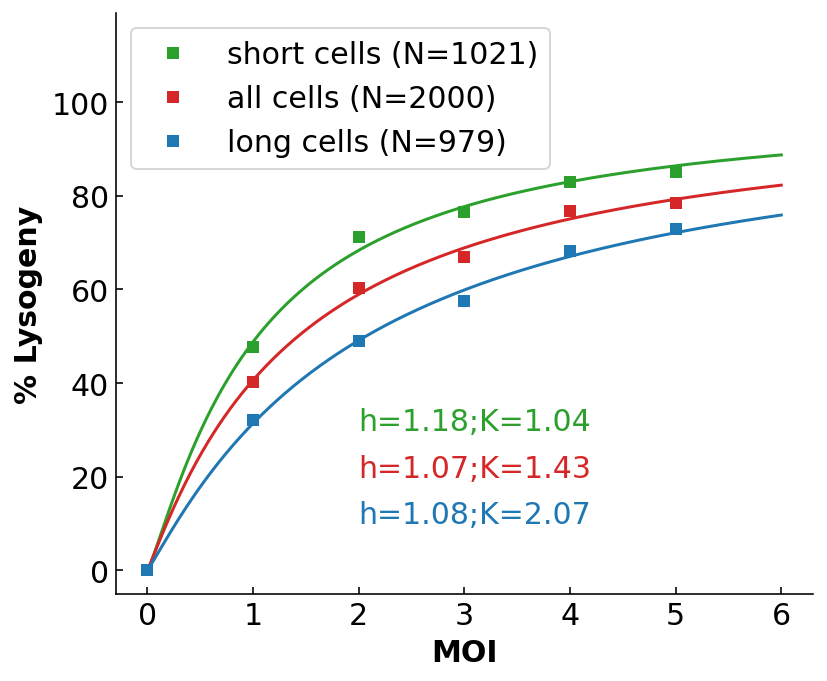

In [106]:
h = 2.07;
K = 1.17;

m_a = np.zeros(6); m_s = np.zeros(6); m_l = np.zeros(6);
N_a = 0; N_s = 0; N_l = 0;
l_all = np.zeros((6,400))

for m in range(1,6):
    l_list = np.random.normal(1.0, 0.2, 400)
    l_all[m,:] = l_list;
    t_s = np.array([])
    t_l = np.array([])
    t_a = np.array([])
    for l in l_list:
        tmp = single_cell_decision_simulator(m,l,h,K,1)
        t_a = np.append(t_a, tmp)
        if l > 1.0:
            t_l = np.append(t_l, tmp)
            N_l += 1;
        else:
            t_s = np.append(t_s, tmp)
            N_s += 1;
    m_s[m] = np.mean(t_s)
    m_a[m] = np.mean(t_a)
    m_l[m] = np.mean(t_l)
N_a = N_s + N_l
##################fit####################
xx = np.array(range(0,6))
xxx = np.linspace(0,6,1000)
popt1, pcov1 = curve_fit(Hill_equation, xx[1:], m_s[1:],p0=[1,1])
popt2, pcov2 = curve_fit(Hill_equation, xx[1:], m_a[1:],p0=[1,1])
popt3, pcov3 = curve_fit(Hill_equation, xx[1:], m_l[1:],p0=[1,1])
##################plot####################
matplotlib.rcParams.update({"figure.figsize": (6,5)})
fig, ax = plt.subplots()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
plotStyles={"markersize":5,"markeredgewidth":1.0,"linewidth":2.0}
plot(xx,m_s*100,'s',color='tab:green',label='short cells (N='+str(N_s)+')',**plotStyles)
plot(xxx,Hill_equation(xxx,*popt1)*100,'-',color='tab:green')
text(2,30,'h='+str(round(popt1[0],2))+';K='+str(round(popt1[1],2)),color='tab:green')

plot(xx,m_a*100,'s',color='tab:red',label='all cells (N='+str(N_a)+')',**plotStyles)
plot(xxx,Hill_equation(xxx,*popt2)*100,'-',color='tab:red')
text(2,20,'h='+str(round(popt2[0],2))+';K='+str(round(popt2[1],2)),color='tab:red')

plot(xx,m_l*100,'s',color='tab:blue',label='long cells (N='+str(N_l)+')',**plotStyles)
plot(xxx,Hill_equation(xxx,*popt3)*100,'-',color='tab:blue')
text(2,10,'h='+str(round(popt3[0],2))+';K='+str(round(popt3[1],2)),color='tab:blue')

legend(loc='upper left')

ylim((-5,119))
xlabel('MOI',weight='bold'); ylabel('% Lysogeny',weight='bold')
tick_params(axis="y",direction="in")
tick_params(axis="x",direction="in")

tight_layout()

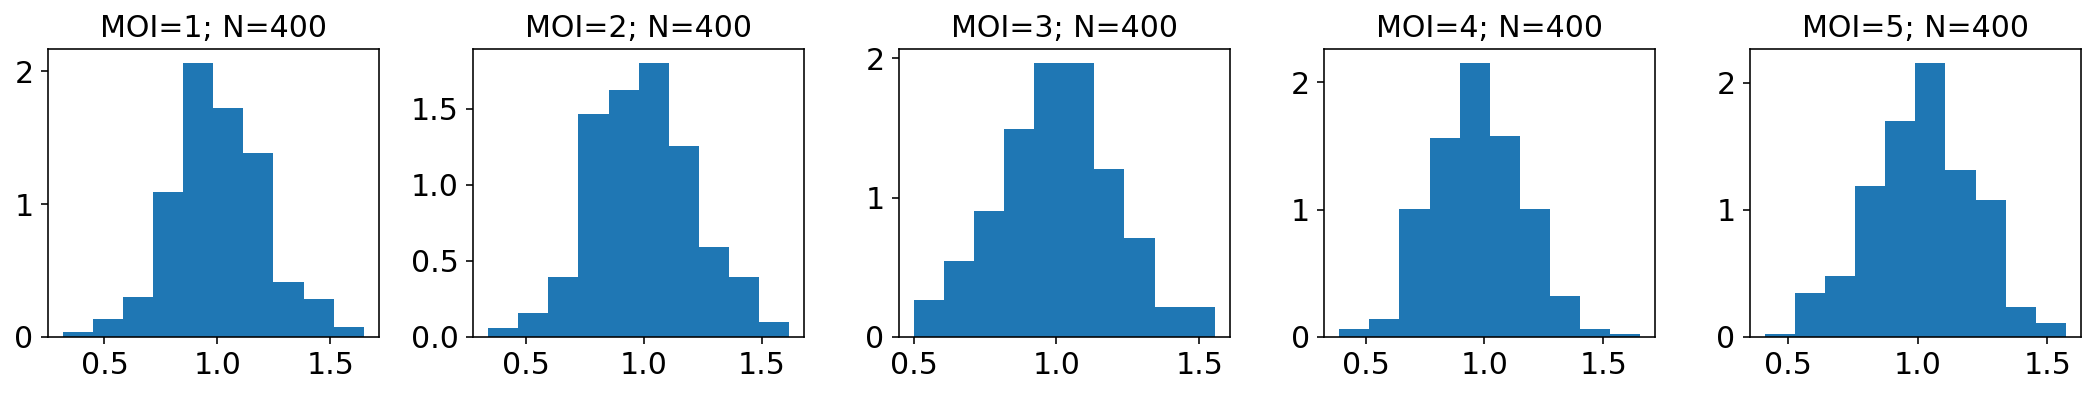

In [109]:
matplotlib.rcParams.update({"figure.figsize": (15,3)})
for i in range(1,6):
    subplot(1,5,i)
    hist(l_all[i],density=True)
    ylabel()
    title('MOI='+str(i)+'; N=400')
tight_layout()

## 2.2 Reproduce Fig 3A

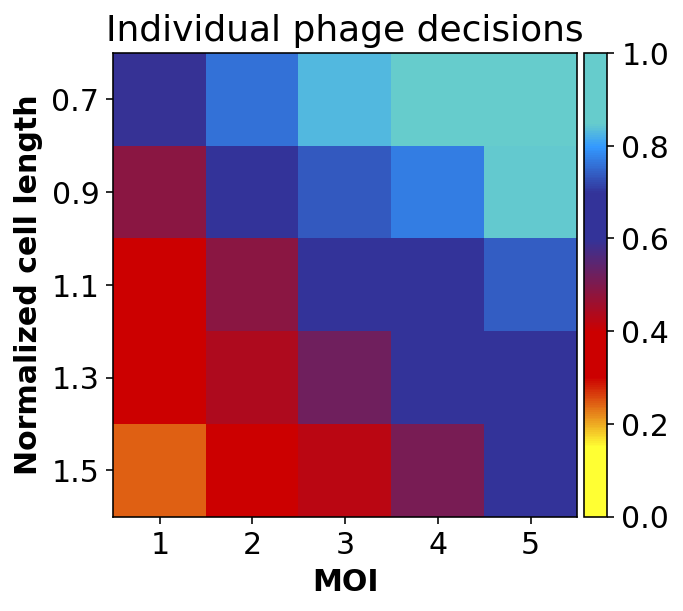

In [53]:
N = 1000;
m_list = [1,2,3,4,5]
l_list = [0.7, 0.9, 1.1, 1.3,1.5]
output1 = np.zeros((len(m_list),len(l_list)))
output2 = np.zeros((len(m_list),len(l_list)))
for i in range(0,len(m_list)):
    for j in range(0,len(l_list)):
        tmp1=single_cell_decision_simulator(m_list[i],l_list[j],h,K,N)
        tmp2=single_cell_decision_simulator_2(m_list[i],l_list[j],1.0,K,N)
        output1[i,j] = np.mean(tmp1)
        output2[i,j] = np.mean(tmp2)

matplotlib.rcParams.update({"figure.figsize": (5,5)})
fig, ax = plt.subplots(1,1)
img = ax.imshow(output1.T,vmin=0, vmax=1, cmap=rvb,interpolation='none')
#plot x and y label
x_label_list = ['1', '2', '3', '4','5']; y_label_list = ['0.7', '0.9', '1.1', '1.3','1.5']
ax.set_xticks([0,1,2,3,4])
ax.set_xticklabels(x_label_list)
ax.set_yticks([0,1,2,3,4])
ax.set_yticklabels(y_label_list)
ax.set_xlabel('MOI',weight='bold')
ax.set_ylabel('Normalized cell length',weight='bold')

#display values
#for (i, j), z in np.ndenumerate(output2.T):
#    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')

#adjust color bar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img,cax=cax)
ax.set_title('Individual phage decisions',fontsize=18)
tight_layout()

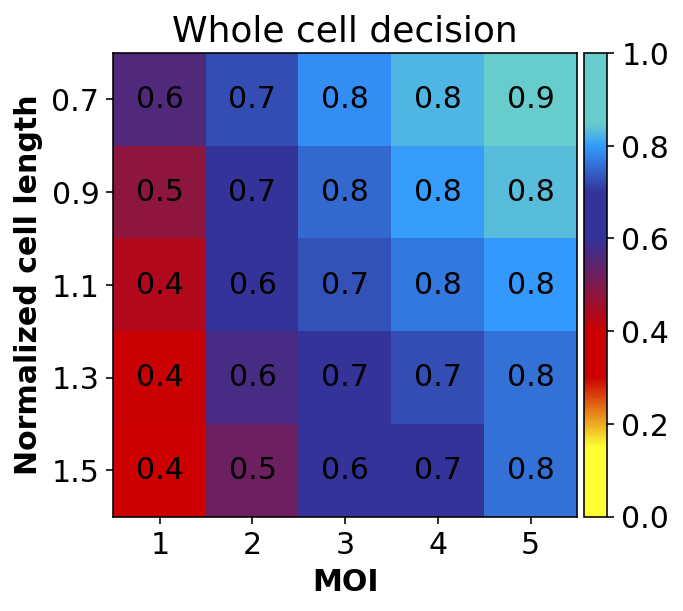

In [52]:
matplotlib.rcParams.update({"figure.figsize": (5,5)})
fig, ax = plt.subplots(1,1)
img = ax.imshow(output2.T,vmin=0, vmax=1, cmap=rvb,interpolation='none')

#plot x and y label
x_label_list = ['1', '2', '3', '4','5']; y_label_list = ['0.7', '0.9', '1.1', '1.3','1.5']
ax.set_xticks([0,1,2,3,4])
ax.set_xticklabels(x_label_list)
ax.set_yticks([0,1,2,3,4])
ax.set_yticklabels(y_label_list)
ax.set_xlabel('MOI',weight='bold')
ax.set_ylabel('Normalized cell length',weight='bold')

#display values
for (i, j), z in np.ndenumerate(output2.T):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
ax.set_title('Whole cell decision')

#adjust color bar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img,cax=cax)
ax.set_title('Whole cell decision',fontsize=18)
tight_layout()

## 2.3 Reproduce Fig 3C

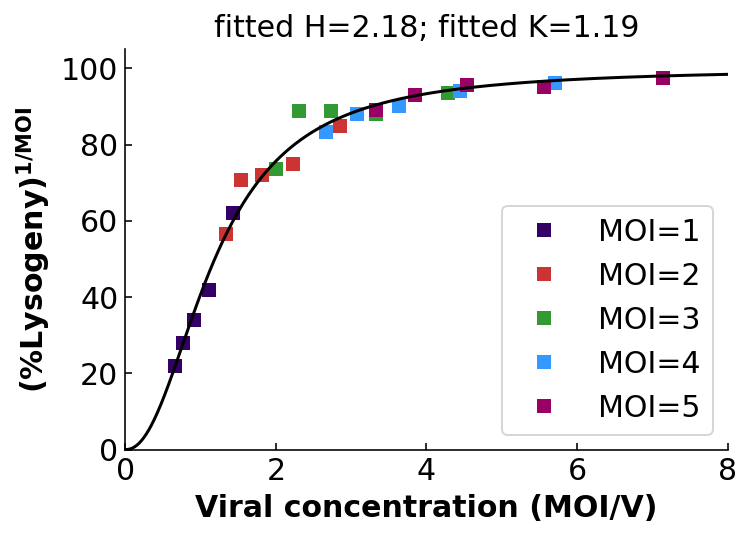

In [66]:
colors = ['#330066','#CC3333','#339933','#3399FF','#990066']

matplotlib.rcParams.update({"figure.figsize": (5.5,4)})
fig, ax = plt.subplots()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

x__ = np.array([])
y__ = np.array([])
for i in range(0,len(m_list)):
    x_ = np.array([])
    y_ = np.array([])
    for j in range(0,len(l_list)):
        N = 50;
        tmp1=single_cell_decision_simulator(m_list[i],l_list[j],h,K,N)
        x_ = np.append(x_,m_list[i]/l_list[j])
        y_ = np.append(y_, (np.mean(tmp1))**(1/m_list[i]))
    plot(x_,y_*100,'s',color=colors[i],label='MOI='+str(m_list[i]))
    x__ = np.append(x__, x_)
    y__ = np.append(y__, y_)

index__ = np.argsort(x__)
x__ = x__[index__]
y__ = y__[index__]
popt, pcov = curve_fit(Hill_equation, x__, y__)
title('fitted H='+str(round(popt[0],2))+'; fitted K='+str(round(popt[1],2)))

xx = np.linspace(0,8,1000)
plot(xx,Hill_equation(xx,*popt)*100,color='black')

xlim((0,8));ylim((0,105))
xlabel('Viral concentration (MOI/V)',weight='bold'); ylabel(r'$\mathbf{(\% Lysogeny)^{1/MOI}}$',weight='bold')
tick_params(axis="y",direction="in")
tick_params(axis="x",direction="in")

legend()
tight_layout()